### Support Vector Regression Model

Our [previous investigation](https://github.com/akshaysuresh1/may22-barrel/blob/main/Modeling/npk_cluster_trends.ipynb) informed us of a predominantly linear relationship between fertilizer consumption per area and rice yield across most clusters. Here, let's explore the relationship learnt by [support vector regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html).

In [1]:
# Load relevant packages.
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt

# sklearn model
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse

sns.set_style('whitegrid')

In [2]:
# Load clustered data.
df = pd.read_csv('../Final_data/rice_yield_clusters.csv')

In [3]:
# Compute fertilizer consumption per unit area.
df['N_per_area'] = df['nitrogen']/df['RICE.AREA..1000.ha.']
df['P_per_area'] = df['phosphate']/df['RICE.AREA..1000.ha.']
df['K_per_area'] = df['potash']/df['RICE.AREA..1000.ha.']

In [4]:
N_clusters = df['Cluster'].max() - df['Cluster'].min() + 1
print('No. of clusters in data = %d'% (N_clusters))

No. of clusters in data = 6


In [5]:
# Calculate no. of samples per cluster.
Nsamples = np.zeros((N_clusters))
for i in range(N_clusters):
    Nsamples[i] = len(df[df['Cluster']==i+1])
    print('We have %d data samples for cluster %d.'% (Nsamples[i], i+1))

We have 3410 data samples for cluster 1.
We have 1266 data samples for cluster 2.
We have 3077 data samples for cluster 3.
We have 624 data samples for cluster 4.
We have 1823 data samples for cluster 5.
We have 280 data samples for cluster 6.


### Hyperparameter tuning

Support vector regression involves two chief hyperparameters, i.e., $C$ and $\epsilon$. The value $1/C \in  	\mathbb{R}^{+}$ controls the strength of the regularization. On the other hand, $\epsilon$ is a slack variable that dictates the margin by a which a certain observation can violate the support vector boundary. <br>

We have already seen that of all clusters, cluster 1 has the greatest number of samples. Also, of the three kinds of fertilizers, nitrogen consumption shows the largest variance within each cluster. Therefore, to save time, let us use the nitrogen fertilizer data from cluster 1 to tune $C$. We will fix $\epsilon = 0.1$ throughout this notebook. <br>

Let us experiment with a [radial basis function](https://towardsdatascience.com/radial-basis-function-rbf-kernel-the-go-to-kernel-acf0d22c798a) (`rbf`) kernel to capture any non-linearities missed by our [simple linear regression model](https://github.com/akshaysuresh1/may22-barrel/blob/main/Modeling/npk_slr.ipynb).

In [6]:
# Create a K-fold object.
nfold = 10
kfold = KFold(nfold, random_state = 614, shuffle=True)

# Values of C explored =
C_values = np.geomspace(1e-2, 1e5, 8)

In [7]:
# Select cluster 1 data.
cluster1_data = df[df['Cluster']==1].copy()

# Store root mean squared error on N consumption for cluster 1.
rmse = np.zeros((nfold, len(C_values)))

In [8]:
# Split into train and test data sets.
c1_train, c1_test = train_test_split(cluster1_data, test_size=0.2, shuffle=True, random_state=440)

# Loop over k-folds.
i = 0
for train_index, test_index in kfold.split(c1_train):
    # Training set
    c1_tt = c1_train.iloc[train_index]
    # Holdout set
    c1_ho = c1_train.iloc[test_index]
    
    j = 0
    for c in C_values:
        # Create model object within pipeline.
        pipe = Pipeline([('scale', StandardScaler()),
                         ('svr', SVR(kernel='rbf',C=c, epsilon=0.1, max_iter=-1))
                        ])
        
        # Fit model.
        pipe.fit(c1_tt['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1), c1_tt['N_per_area'])
        
        # Predict on holdout set.
        pred_ho = pipe.predict(c1_ho['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
        
        # Compute RMSE on holdout set.
        rmse[i,j] = mse(c1_ho['N_per_area'], pred_ho, squared=False)
        j+= 1
    i+=1

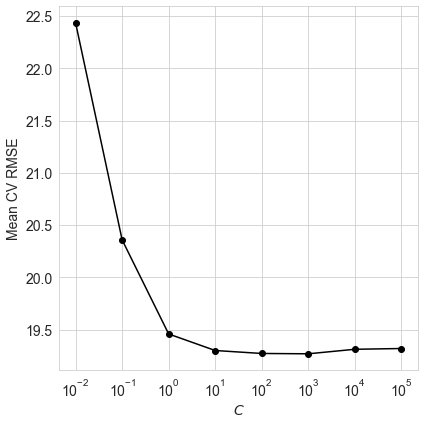

In [9]:
# Plot mean cross-validation RMSE for different depths.
fig = plt.figure(1, figsize=(6,6), tight_layout=True)
plt.semilogx(C_values, np.mean(rmse, axis=0), '-ok')
plt.xlabel(r'$C$', fontsize=14)
plt.ylabel('Mean CV RMSE', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

$C = 10$ seems to be a suitable choice around the elbow of the curve. With $C=10$ and $\epsilon=0.1$, let's fit support vector regressors to the NPK data for each of our clusters.

Cluster 1
Size of test set = 682
Fold 1: Train/validation data size = [2455, 273]
N_RMSE = 16.2130, P_RMSE = 8.1362, K_RMSE = 4.4231

Fold 2: Train/validation data size = [2455, 273]
N_RMSE = 21.0615, P_RMSE = 8.6204, K_RMSE = 3.8487

Fold 3: Train/validation data size = [2455, 273]
N_RMSE = 19.6473, P_RMSE = 6.6696, K_RMSE = 4.0401

Fold 4: Train/validation data size = [2455, 273]
N_RMSE = 21.1263, P_RMSE = 10.6216, K_RMSE = 5.3238

Fold 5: Train/validation data size = [2455, 273]
N_RMSE = 19.1199, P_RMSE = 7.1969, K_RMSE = 3.5592

Fold 6: Train/validation data size = [2455, 273]
N_RMSE = 17.5990, P_RMSE = 6.5740, K_RMSE = 3.0190

Fold 7: Train/validation data size = [2455, 273]
N_RMSE = 23.4225, P_RMSE = 11.6088, K_RMSE = 6.3016

Fold 8: Train/validation data size = [2455, 273]
N_RMSE = 17.8843, P_RMSE = 6.1712, K_RMSE = 4.0245

Fold 9: Train/validation data size = [2456, 272]
N_RMSE = 18.1865, P_RMSE = 5.9889, K_RMSE = 3.1323

Fold 10: Train/validation data size = [2456, 272]
N_RMSE

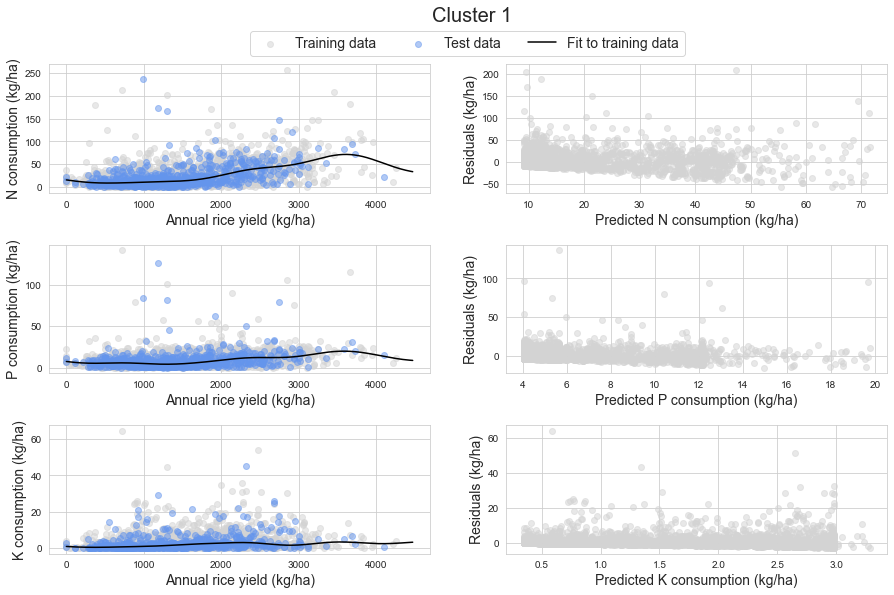

Cluster 2
Size of test set = 254
Fold 1: Train/validation data size = [910, 102]
N_RMSE = 11.3443, P_RMSE = 5.5333, K_RMSE = 6.7381

Fold 2: Train/validation data size = [910, 102]
N_RMSE = 11.5529, P_RMSE = 4.6129, K_RMSE = 5.2196

Fold 3: Train/validation data size = [911, 101]
N_RMSE = 10.1794, P_RMSE = 6.1007, K_RMSE = 7.2379

Fold 4: Train/validation data size = [911, 101]
N_RMSE = 9.9998, P_RMSE = 5.1128, K_RMSE = 6.0665

Fold 5: Train/validation data size = [911, 101]
N_RMSE = 13.6275, P_RMSE = 6.8669, K_RMSE = 9.6942

Fold 6: Train/validation data size = [911, 101]
N_RMSE = 12.2832, P_RMSE = 6.1157, K_RMSE = 6.2592

Fold 7: Train/validation data size = [911, 101]
N_RMSE = 12.6138, P_RMSE = 7.3821, K_RMSE = 7.9831

Fold 8: Train/validation data size = [911, 101]
N_RMSE = 16.5426, P_RMSE = 6.1839, K_RMSE = 7.1321

Fold 9: Train/validation data size = [911, 101]
N_RMSE = 10.4124, P_RMSE = 4.9273, K_RMSE = 6.5598

Fold 10: Train/validation data size = [911, 101]
N_RMSE = 13.7607, P

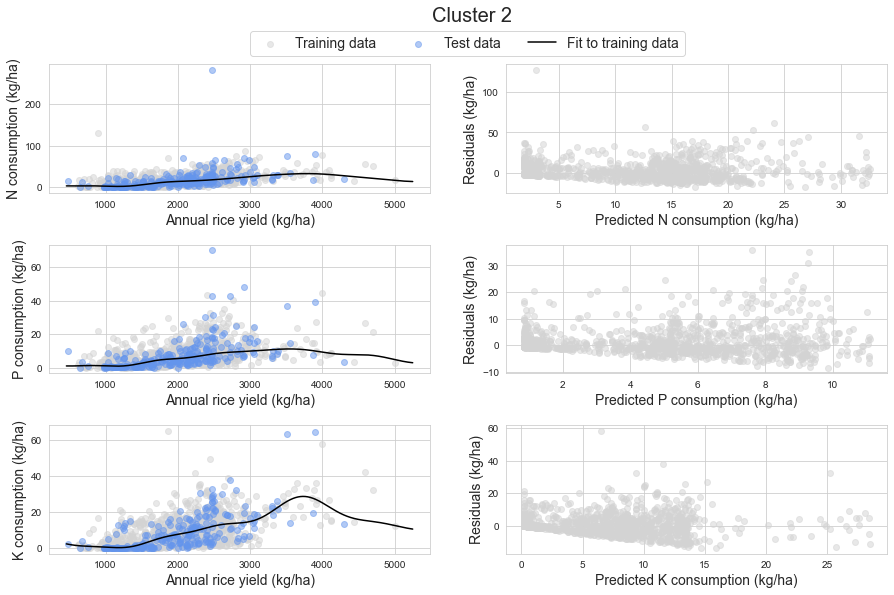

Cluster 3
Size of test set = 616
Fold 1: Train/validation data size = [2214, 247]
N_RMSE = 20.3164, P_RMSE = 6.7718, K_RMSE = 4.4762

Fold 2: Train/validation data size = [2215, 246]
N_RMSE = 19.9260, P_RMSE = 9.0277, K_RMSE = 6.6878

Fold 3: Train/validation data size = [2215, 246]
N_RMSE = 19.8936, P_RMSE = 8.5470, K_RMSE = 4.3128

Fold 4: Train/validation data size = [2215, 246]
N_RMSE = 22.4066, P_RMSE = 9.1806, K_RMSE = 5.5594

Fold 5: Train/validation data size = [2215, 246]
N_RMSE = 21.1287, P_RMSE = 8.8437, K_RMSE = 5.0481

Fold 6: Train/validation data size = [2215, 246]
N_RMSE = 22.5002, P_RMSE = 10.0440, K_RMSE = 5.9466

Fold 7: Train/validation data size = [2215, 246]
N_RMSE = 20.1303, P_RMSE = 7.6580, K_RMSE = 5.3042

Fold 8: Train/validation data size = [2215, 246]
N_RMSE = 19.2141, P_RMSE = 7.9728, K_RMSE = 5.5659

Fold 9: Train/validation data size = [2215, 246]
N_RMSE = 20.5963, P_RMSE = 7.7996, K_RMSE = 7.6951

Fold 10: Train/validation data size = [2215, 246]
N_RMSE 

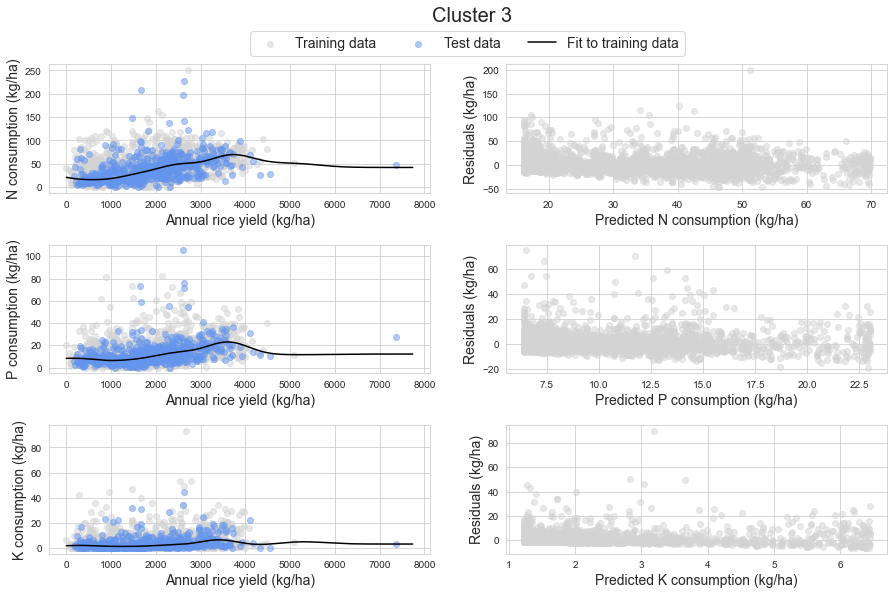

Cluster 4
Size of test set = 125
Fold 1: Train/validation data size = [449, 50]
N_RMSE = 23.2904, P_RMSE = 10.4827, K_RMSE = 15.5232

Fold 2: Train/validation data size = [449, 50]
N_RMSE = 28.7694, P_RMSE = 14.6532, K_RMSE = 16.9838

Fold 3: Train/validation data size = [449, 50]
N_RMSE = 26.9673, P_RMSE = 12.9284, K_RMSE = 15.1237

Fold 4: Train/validation data size = [449, 50]
N_RMSE = 28.9956, P_RMSE = 15.7730, K_RMSE = 15.8465

Fold 5: Train/validation data size = [449, 50]
N_RMSE = 24.2163, P_RMSE = 11.6988, K_RMSE = 19.2467

Fold 6: Train/validation data size = [449, 50]
N_RMSE = 26.2471, P_RMSE = 11.5884, K_RMSE = 12.7780

Fold 7: Train/validation data size = [449, 50]
N_RMSE = 38.7462, P_RMSE = 23.8727, K_RMSE = 10.4888

Fold 8: Train/validation data size = [449, 50]
N_RMSE = 19.9100, P_RMSE = 7.6600, K_RMSE = 8.0225

Fold 9: Train/validation data size = [449, 50]
N_RMSE = 20.5198, P_RMSE = 9.2662, K_RMSE = 10.1285

Fold 10: Train/validation data size = [450, 49]
N_RMSE = 41.4

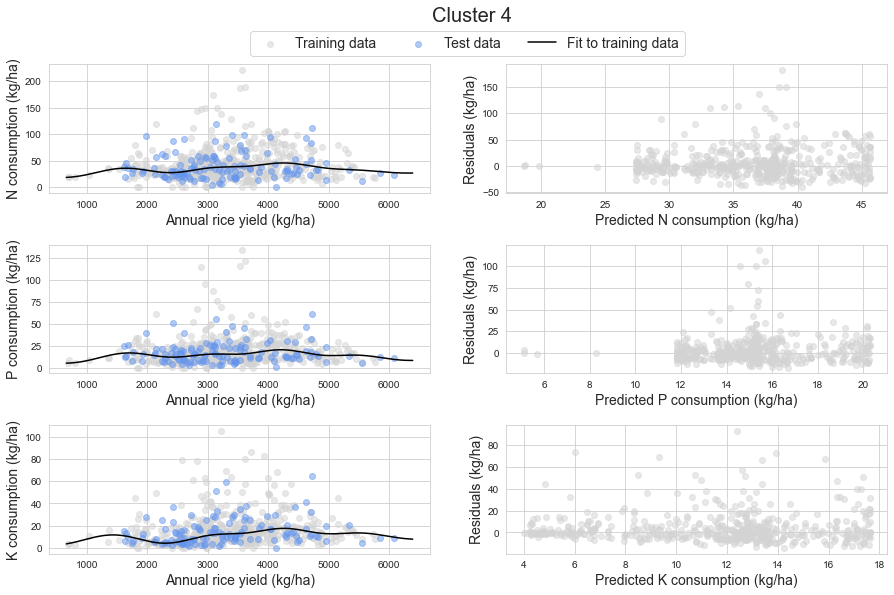

Cluster 5
Size of test set = 365
Fold 1: Train/validation data size = [1312, 146]
N_RMSE = 23.8689, P_RMSE = 7.5876, K_RMSE = 3.2595

Fold 2: Train/validation data size = [1312, 146]
N_RMSE = 22.1605, P_RMSE = 8.2359, K_RMSE = 3.8209

Fold 3: Train/validation data size = [1312, 146]
N_RMSE = 19.6986, P_RMSE = 8.2018, K_RMSE = 2.8029

Fold 4: Train/validation data size = [1312, 146]
N_RMSE = 20.4545, P_RMSE = 7.2710, K_RMSE = 4.0728

Fold 5: Train/validation data size = [1312, 146]
N_RMSE = 20.2565, P_RMSE = 6.7267, K_RMSE = 3.4694

Fold 6: Train/validation data size = [1312, 146]
N_RMSE = 18.1699, P_RMSE = 6.1904, K_RMSE = 3.1221

Fold 7: Train/validation data size = [1312, 146]
N_RMSE = 21.6489, P_RMSE = 8.5856, K_RMSE = 3.8573

Fold 8: Train/validation data size = [1312, 146]
N_RMSE = 21.0728, P_RMSE = 8.6830, K_RMSE = 3.9020

Fold 9: Train/validation data size = [1313, 145]
N_RMSE = 22.2787, P_RMSE = 6.3322, K_RMSE = 2.3254

Fold 10: Train/validation data size = [1313, 145]
N_RMSE =

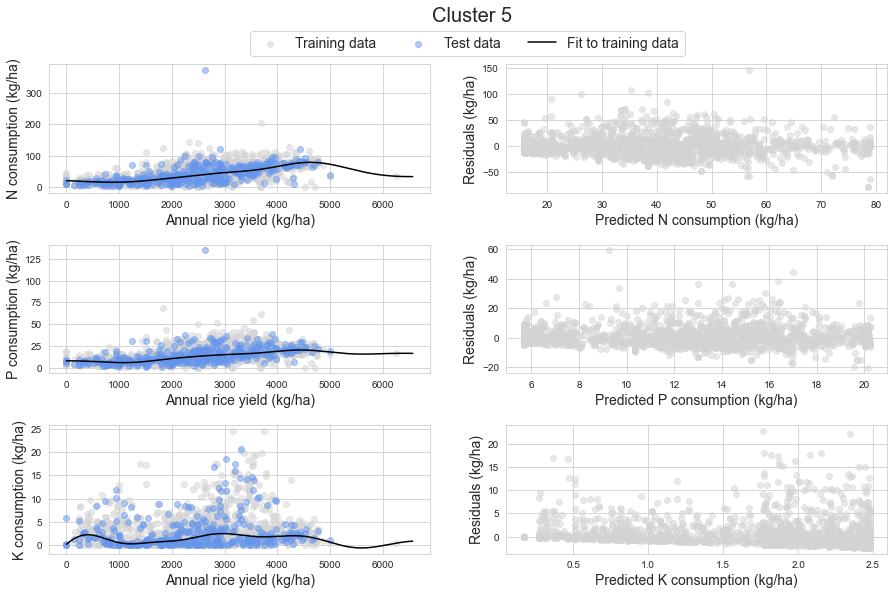

Cluster 6
Size of test set = 56
Fold 1: Train/validation data size = [201, 23]
N_RMSE = 21.7772, P_RMSE = 11.9779, K_RMSE = 12.2142

Fold 2: Train/validation data size = [201, 23]
N_RMSE = 20.4357, P_RMSE = 7.7136, K_RMSE = 11.0671

Fold 3: Train/validation data size = [201, 23]
N_RMSE = 16.8793, P_RMSE = 6.1356, K_RMSE = 6.3812

Fold 4: Train/validation data size = [201, 23]
N_RMSE = 18.4729, P_RMSE = 5.6940, K_RMSE = 5.3800

Fold 5: Train/validation data size = [202, 22]
N_RMSE = 15.0982, P_RMSE = 5.8404, K_RMSE = 7.2124

Fold 6: Train/validation data size = [202, 22]
N_RMSE = 16.6860, P_RMSE = 6.3747, K_RMSE = 7.0484

Fold 7: Train/validation data size = [202, 22]
N_RMSE = 12.8100, P_RMSE = 6.2031, K_RMSE = 9.7302

Fold 8: Train/validation data size = [202, 22]
N_RMSE = 20.8886, P_RMSE = 7.9931, K_RMSE = 7.6185

Fold 9: Train/validation data size = [202, 22]
N_RMSE = 21.6180, P_RMSE = 11.7105, K_RMSE = 5.1638

Fold 10: Train/validation data size = [202, 22]
N_RMSE = 13.8909, P_RMSE 

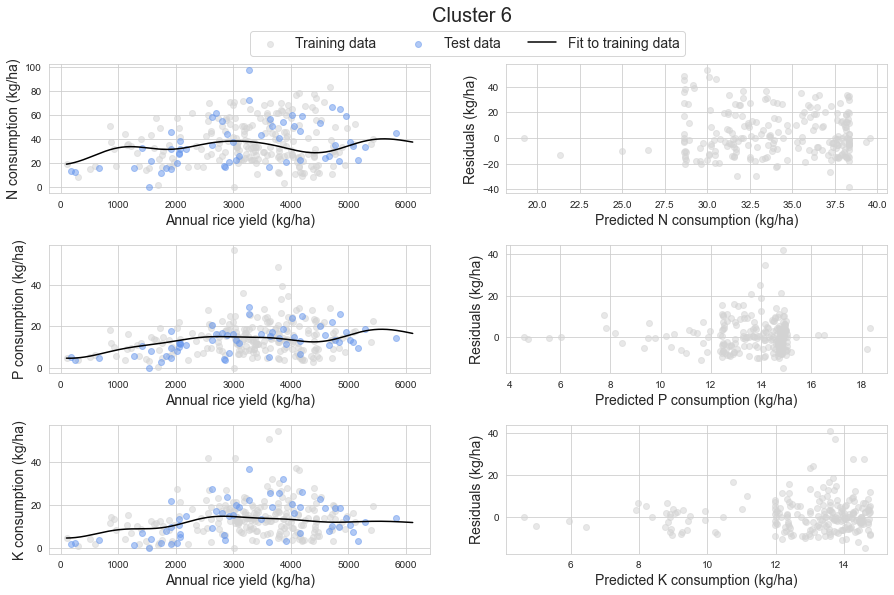

In [10]:
# Store mean-squared errors on test NPK data for each cluster.
N_rmse_test = np.zeros(N_clusters)
P_rmse_test = np.zeros(N_clusters)
K_rmse_test = np.zeros(N_clusters)

# Loop over clusters.
for i in range(N_clusters):
    start_time = time.time()
    selection = df[df['Cluster']==i+1]
    
    # Train-test split
    df_train, df_test = train_test_split(selection.copy(), test_size=0.2, shuffle=True, random_state=440)
    print('Cluster %d'% (i+1))
    print('Size of test set = %d'% (len(df_test)))
    
    # Create model objects, one each for N, P, and K.
    pipe_N = Pipeline([('scale', StandardScaler()),
                       ('svr', SVR(kernel='rbf',C=10.0, epsilon=0.1, max_iter=-1))])
    pipe_P = Pipeline([('scale', StandardScaler()),
                       ('svr', SVR(kernel='rbf',C=10.0, epsilon=0.1, max_iter=-1))])
    pipe_K = Pipeline([('scale', StandardScaler()),
                       ('svr', SVR(kernel='rbf',C=10.0, epsilon=0.1, max_iter=-1))])
    
    j = 0 # k-fold index
    # Loop through k-fold.
    for train_index, test_index in kfold.split(df_train):
        # Training set
        df_tt = df_train.iloc[train_index]
        # Holdout set
        df_ho = df_train.iloc[test_index]
        print('Fold %d: Train/validation data size = [%d, %d]'% (j+1, len(df_tt), len(df_ho)))

        # Fit models to NPK data.
        pipe_N.fit(df_tt['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1), df_tt['N_per_area'])
        pipe_P.fit(df_tt['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1), df_tt['P_per_area'])
        pipe_K.fit(df_tt['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1), df_tt['K_per_area'])        
        
        # Obtain predictions on the holdout set.
        pred_N = pipe_N.predict(df_ho['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
        pred_P = pipe_P.predict(df_ho['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
        pred_K = pipe_K.predict(df_ho['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
        
        # Compute root mean squared error (RMSE) on the holdout set.
        rmse_fold_N = mse(df_ho['N_per_area'], pred_N, squared=False)
        rmse_fold_P = mse(df_ho['P_per_area'], pred_P, squared=False)
        rmse_fold_K = mse(df_ho['K_per_area'], pred_K, squared=False)
        print('N_RMSE = %.4f, P_RMSE = %.4f, K_RMSE = %.4f\n'% (rmse_fold_N, rmse_fold_P, rmse_fold_K))
        j+=1
  
    # Predict on test data.
    test_pred_N = pipe_N.predict(df_test['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
    test_pred_P = pipe_P.predict(df_test['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
    test_pred_K = pipe_K.predict(df_test['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
    
    # Record RMSE on test data.
    N_rmse_test[i] = mse(df_test['N_per_area'], test_pred_N, squared=False)
    P_rmse_test[i] = mse(df_test['P_per_area'], test_pred_P, squared=False)    
    K_rmse_test[i] = mse(df_test['K_per_area'], test_pred_K, squared=False)    
    print('RMSE on N test data = %.4f'% (N_rmse_test[i]))
    print('RMSE on P test data = %.4f'% (P_rmse_test[i]))
    print('RMSE on K test data = %.4f'% (K_rmse_test[i]))
    
    # Asssess time taken for model fitting.
    end_time = time.time()
    model_fit_time = (end_time - start_time)/60.0
    print('SupportVectorRegressor model fitting took %.2f minutes.'% (model_fit_time))
    
    # Line fit for plotting
    x = np.linspace(0.95*selection['RICE.YIELD..kg.per.ha.'].min(),
                    1.05*selection['RICE.YIELD..kg.per.ha.'].max(), 1000)
    y_N = pipe_N.predict(x.reshape(-1,1))
    y_P = pipe_P.predict(x.reshape(-1,1))
    y_K = pipe_K.predict(x.reshape(-1,1))
    
    # Compute prediction on training data.
    train_pred_N = pipe_N.predict(df_train['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
    train_pred_P = pipe_P.predict(df_train['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
    train_pred_K = pipe_K.predict(df_train['RICE.YIELD..kg.per.ha.'].values.reshape(-1,1))
    
    # Compute residual on training data.
    train_residual_N = df_train['N_per_area'] - train_pred_N
    train_residual_P = df_train['P_per_area'] - train_pred_P
    train_residual_K = df_train['K_per_area'] - train_pred_K    
    
    # Plotting
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,8))
    # Row 0, column 0: Nitrogen consumption (kg/ha) vs. rice yield (kg/ha)
    l1 = axes[0,0].scatter(x=df_train['RICE.YIELD..kg.per.ha.'], y=df_train['N_per_area'], c='lightgray', alpha=0.5,
                     label='Training data')
    l2 = axes[0,0].scatter(x=df_test['RICE.YIELD..kg.per.ha.'], y=df_test['N_per_area'], c='cornflowerblue', alpha=0.5,
                     label='Test data') 
    l3, = axes[0,0].plot(x, y_N, '-k', label='Fit')
    axes[0,0].set_xlabel('Annual rice yield (kg/ha)', fontsize=14)
    axes[0,0].set_ylabel('N consumption (kg/ha)', fontsize=14)
    # Row 0, column 1: Residual on training data vs. predicted N consumption
    axes[0,1].scatter(x=train_pred_N, y=train_residual_N, c='lightgray', alpha=0.5)
    axes[0,1].set_xlabel('Predicted N consumption (kg/ha)', fontsize=14)
    axes[0,1].set_ylabel('Residuals (kg/ha)', fontsize=14)
    # Row 1, column 0: Phosphate consumption (kg/ha) vs. rice yield (kg/ha)
    axes[1,0].scatter(x=df_train['RICE.YIELD..kg.per.ha.'], y=df_train['P_per_area'], c='lightgray', alpha=0.5)
    axes[1,0].scatter(x=df_test['RICE.YIELD..kg.per.ha.'], y=df_test['P_per_area'], c='cornflowerblue', alpha=0.5) 
    axes[1,0].plot(x, y_P, '-k')
    axes[1,0].set_xlabel('Annual rice yield (kg/ha)', fontsize=14)
    axes[1,0].set_ylabel('P consumption (kg/ha)', fontsize=14)
    # Row 1, column 1: Residual on training data vs. predicted P consumption
    axes[1,1].scatter(x=train_pred_P, y=train_residual_P, c='lightgray', alpha=0.5)
    axes[1,1].set_xlabel('Predicted P consumption (kg/ha)', fontsize=14)
    axes[1,1].set_ylabel('Residuals (kg/ha)', fontsize=14)
    # Row 2, column 0: Potash consumption (kg/ha) vs. rice yield (kg/ha)
    axes[2,0].scatter(x=df_train['RICE.YIELD..kg.per.ha.'], y=df_train['K_per_area'], c='lightgray', alpha=0.5)
    axes[2,0].scatter(x=df_test['RICE.YIELD..kg.per.ha.'], y=df_test['K_per_area'], c='cornflowerblue', alpha=0.5) 
    axes[2,0].plot(x, y_K, '-k')
    axes[2,0].set_xlabel('Annual rice yield (kg/ha)', fontsize=14)
    axes[2,0].set_ylabel('K consumption (kg/ha)', fontsize=14)
    # Row 2, column 1: Residual on training data vs. predicted K consumption
    axes[2,1].scatter(x=train_pred_K, y=train_residual_K, c='lightgray', alpha=0.5)
    axes[2,1].set_xlabel('Predicted K consumption (kg/ha)', fontsize=14)
    axes[2,1].set_ylabel('Residuals (kg/ha)', fontsize=14)
    # Figure settings
    fig.subplots_adjust(left=0.01, right=0.98, top=0.90, bottom=0.05, hspace=0.4)
    # Figure legend
    fig.legend((l1,l2,l3), ('Training data','Test data','Fit to training data'), loc=(0.28, 0.905),
               ncol=3, fontsize=14)
    # Figure title
    fig.suptitle('Cluster %d' % (i+1), y=1.0, fontsize=20)
    plt.show()